In [1]:
import os
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from cathedral_rl import cathedral_v0  
from models.ppo_cnn import PPOCNN
from models.ppo_cnn_gae import PPOCNNGAE
import numpy as np
import pygame
from ppo_utils import create_game_gif

In [2]:
################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")



Device set to : NVIDIA RTX A5000


### PPO with just flattened observation

### PPO CNN

In [3]:
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.95                # discount factor
gae_lambda = 0.95

lr_actor = 0.005       # learning rate for actor network
lr_critic = 0.002

In [4]:
board_size = 8
num_episodes = 3000
save_freq = 1000

### Pure self play of PPO vs itself

In [ ]:
def train_ppo_self_play(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()
    
    gif_dir = os.path.join("game_recordings", name)
    os.makedirs(gif_dir, exist_ok=True)
    
    # Get action space and observation shape (should be the same for both players)
    player_0 = "player_0"
    player_1 = "player_1"
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape  # (10, 10, 5)
    
    print(f'n_actions: {n_actions}')
    print(f'observation shape: {obs_shape}')
    
    # Initialize primary PPO agent (the one that will be learning)
    primary_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Initialize target PPO agent (the opponent that will be periodically updated)
    target_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Clone the primary agent weights to target agent initially
    target_agent.policy.load_state_dict(primary_agent.policy.state_dict())
    
    # Define how often to update the target agent (in episodes)
    target_update_frequency = 50
    
    # Training statistics
    list_reward_p0 = []
    list_reward_p1 = []
    policy_checkpoints = []
    list_win_count_p0 = []
    list_win_count_p1 = []
    list_draw_count = []
    
    # Initialize tracking lists
    if not list_win_count_p0:
        list_win_count_p0 = [0]
    if not list_win_count_p1:
        list_win_count_p1 = [0]
    if not list_draw_count:
        list_draw_count = [0]
    
    # Training loop
    for episode in range(num_episodes):
        env.reset()
        list_agents = env.agents
        total_reward_p0 = 0
        total_reward_p1 = 0
        episode_timesteps = 0
        
        # Clear primary agent buffer
        primary_agent.buffer.clear()
        game_over = False
        
        while env.agents:
            current_agent = env.agent_selection
            observation = env.observe(current_agent)
            state = observation["observation"]
            action_mask = observation["action_mask"]
            
            # Player 0 (primary agent) is learning, Player 1 (target agent) is the opponent
            if current_agent == player_0:
                # Primary agent selects action (with exploration)
                action = primary_agent.select_action(state, action_mask)
            else:
                if episode < target_update_frequency :
                    legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
                    action = np.random.choice(legal_moves)
                with torch.no_grad():
                    action = target_agent.select_action(state, action_mask)
            
            # Take action in environment
            env.step(action)
            
            # Get reward
            reward = env.rewards[current_agent]
            
            if (current_agent in env.legal_moves and len(env.legal_moves[player_0]) == 0 and 
                player_1 in env.legal_moves and len(env.legal_moves[player_1]) == 0):
                game_over = True
            
            # Track total rewards
            if current_agent == player_0:
                total_reward_p0 += reward
                
                # Store experiences for the primary agent (player 0)
                primary_agent.buffer.rewards.append(reward)
                
                # Determine if this is a terminal state
                # Terminal if: agent is removed from env.agents OR game is over (no legal moves)
                is_terminal = (current_agent not in env.agents) or game_over
                
                if is_terminal:
                    primary_agent.buffer.is_terminals.append(1)
                else:
                    primary_agent.buffer.is_terminals.append(0)
            else:
                total_reward_p1 += reward
                
                # If player_1's turn ends the game, we need to mark player_0's last state as terminal
                if game_over and len(primary_agent.buffer.is_terminals) > 0:
                    primary_agent.buffer.is_terminals[-1] = 1


                    
            episode_timesteps += 1
        
        # Update primary agent policy using only its experiences
        primary_agent.update()
        
        # Update target network periodically
        if (episode + 1) % target_update_frequency == 0:
            target_agent.policy.load_state_dict(primary_agent.policy.state_dict())
        
        # Collect statistics
        list_reward_p0.append(total_reward_p0)
        list_reward_p1.append(total_reward_p1)
        
        # Update the appropriate counter based on the game outcome
        winner = env.winner
        
        if list_agents[winner] == 'player_0':  # primary agent wins
            list_win_count_p0.append(list_win_count_p0[-1] + 1)
            list_win_count_p1.append(list_win_count_p1[-1])
            list_draw_count.append(list_draw_count[-1])
            
        elif list_agents[winner] == 'player_1':  # target agent wins
            list_win_count_p0.append(list_win_count_p0[-1])
            list_win_count_p1.append(list_win_count_p1[-1] + 1)
            list_draw_count.append(list_draw_count[-1])
            
        elif winner == -1:  # draw
            list_win_count_p0.append(list_win_count_p0[-1])
            list_win_count_p1.append(list_win_count_p1[-1])
            list_draw_count.append(list_draw_count[-1] + 1)
        
        if (episode + 1) % 50 == 0:
            win_rate_p0 = list_win_count_p0[-1] / (episode + 1)
            win_rate_p1 = list_win_count_p1[-1] / (episode + 1)
            draw_rate = list_draw_count[-1] / (episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Primary Agent (P0) - Avg Reward: {sum(list_reward_p0[-100:]) / min(100, len(list_reward_p0)):.2f} - Win Rate: {win_rate_p0:.2f}")
            print(f"  Target Agent (P1) - Avg Reward: {sum(list_reward_p1[-100:]) / min(100, len(list_reward_p1)):.2f} - Win Rate: {win_rate_p1:.2f}")
            print(f"  Draw Rate: {draw_rate:.2f}")
            
        if(episode + 1) % 300 == 0:
            create_game_gif(episode, primary_agent, gif_dir, board_size)
            print(f"Created GIF for episode {episode+1}")
            
        # Save checkpoint
        if (episode+1) % save_freq == 0:
            policy_checkpoints.append(primary_agent.policy.state_dict())
            print("Checkpoint saved")
            
            # Save model
            os.makedirs("model_weights_PPO", exist_ok=True)
            primary_agent.save(f"model_weights_adversarial_PPO/{name}_{episode+1}.pth")
    
    # Save final model and training statistics
    os.makedirs("model_weights_PPO", exist_ok=True)
    print(f'Saving final model')
    torch.save({
        'model_state_dict': primary_agent.policy.state_dict(),
        'list_reward_p0': list_reward_p0,
        'list_reward_p1': list_reward_p1,
        'list_win_count_p0': list_win_count_p0,
        'list_win_count_p1': list_win_count_p1, 
        'list_draw_count': list_draw_count,
        'policy_checkpoints': policy_checkpoints,
        'num_checkpoints': len(policy_checkpoints)
    }, f"model_weights_PPO/{name}_final.pth")
    
    env.close()
    
    return list_reward_p0, list_reward_p1, list_win_count_p0, list_win_count_p1, list_draw_count

In [ ]:
rewards_p0, rewards_p1, win_counts_p0, win_counts_p1, draw_counts = train_ppo_self_play("cathedral_ppo_self_play_adversarial")

n_actions: 1753
observation shape: (8, 8, 5)
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8


/users/eleves-a/2022/adrien.goldszal/Cathedral-RL-CL/PPO/models/ppo_cnn.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_mask_tensor = torch.tensor(action_mask, dtype=torch.bool)


Episode 50/3000
  Primary Agent (P0) - Avg Reward: -12.70 - Win Rate: 0.42
  Target Agent (P1) - Avg Reward: -10.16 - Win Rate: 0.58
  Draw Rate: 0.00


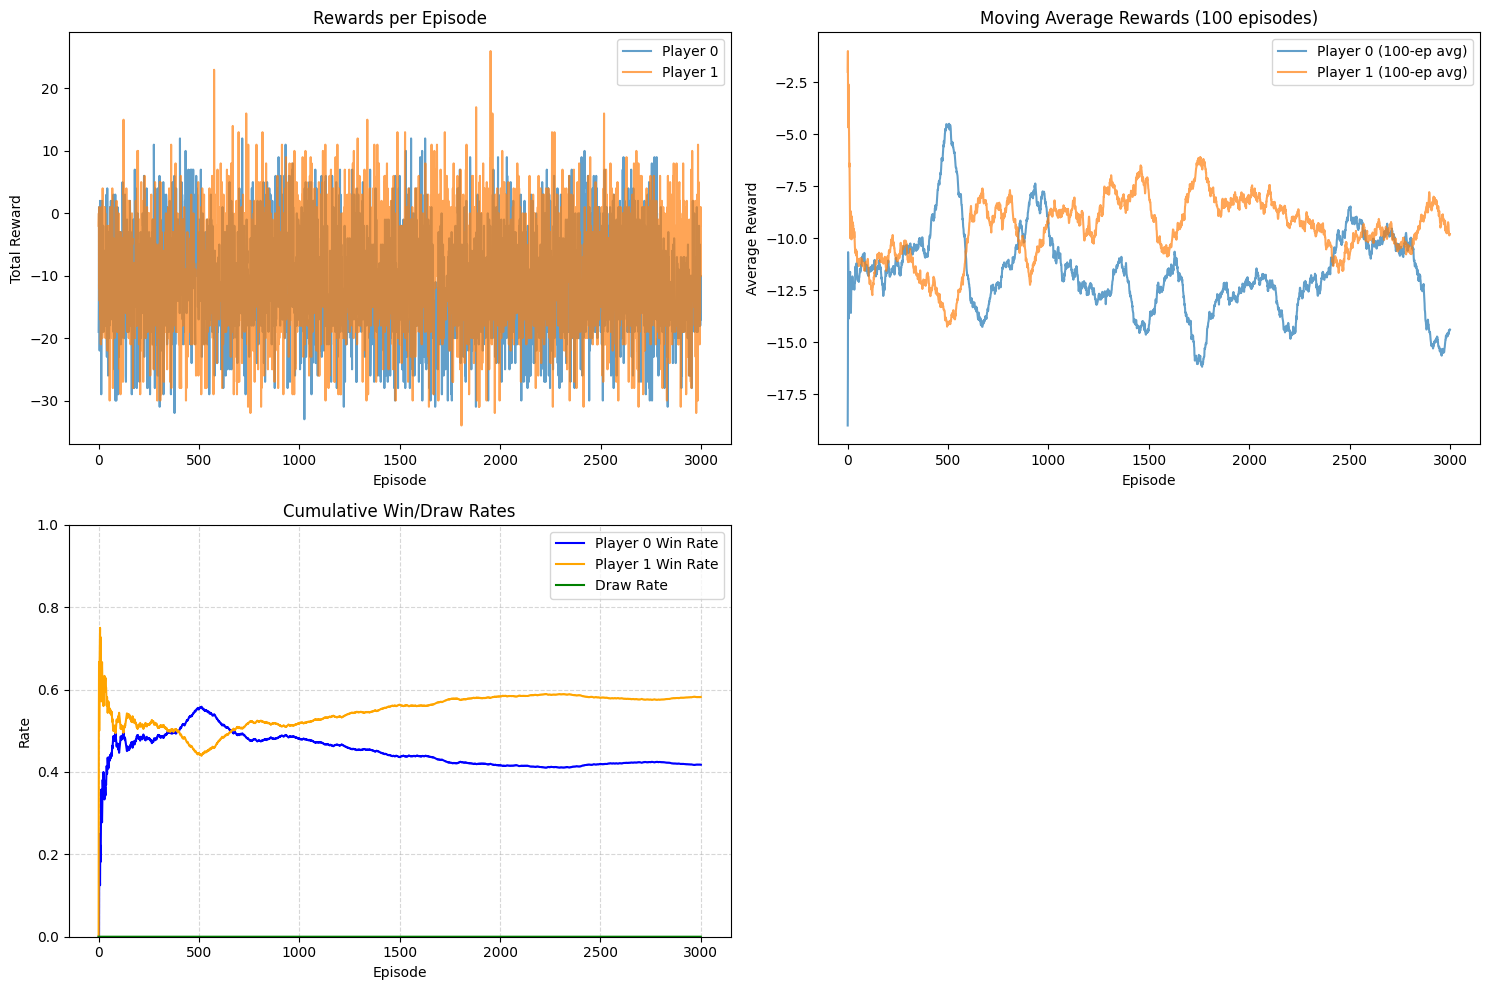

In [ ]:
# Plot results
plt.figure(figsize=(15, 10))

# Plot rewards for both players
plt.subplot(2, 2, 1)
plt.plot(rewards_p0, label='Player 0', alpha=0.7)
plt.plot(rewards_p1, label='Player 1', alpha=0.7)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()

# Plot moving average of rewards for better visualization
window = 100
plt.subplot(2, 2, 2)
p0_avg = [np.mean(rewards_p0[max(0, i-window):i+1]) for i in range(len(rewards_p0))]
p1_avg = [np.mean(rewards_p1[max(0, i-window):i+1]) for i in range(len(rewards_p1))]
plt.plot(p0_avg, label='Player 0 (100-ep avg)', alpha=0.7)
plt.plot(p1_avg, label='Player 1 (100-ep avg)', alpha=0.7)
plt.title("Moving Average Rewards (100 episodes)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()

# Plot win rates for player 0
plt.subplot(2, 2, 3)

# Start from episode 1 to avoid division by zero
start_idx = 1  # Skip episode 0

# Calculate win rates as a function of episodes played
total_games = [i + 1 for i in range(len(win_counts_p0))]  # Assuming one entry per game
p0_win_rates = [wins / games for wins, games in zip(win_counts_p0, total_games)]
p1_win_rates = [wins / games for wins, games in zip(win_counts_p1, total_games)]
draw_rates = [draws / games for draws, games in zip(draw_counts, total_games)]

# Plot with matching dimensions
plt.plot(range(len(p0_win_rates)), p0_win_rates, marker='', label='Player 0 Win Rate', color='blue')
plt.plot(range(len(p1_win_rates)), p1_win_rates, marker='', label='Player 1 Win Rate', color='orange')
plt.plot(range(len(draw_rates)), draw_rates, marker='', label='Draw Rate', color='green')
plt.title("Cumulative Win/Draw Rates")
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("ppo_self_play_training_results.png")
plt.show()

In [ ]:
def evaluate_ppo_against_random(model_path, num_episodes=100, board_size=8, render=False):
    """
    Evaluate a trained PPO agent against a random policy.
    
    Args:
        model_path (str): Path to the saved PPO model weights
        num_episodes (int): Number of evaluation episodes
        board_size (int): Size of the board
        render (bool): Whether to render the game
        
    Returns:
        dict: Evaluation metrics including win rate
    """
    env = cathedral_v0.env(
        board_size=board_size, 
        render_mode="ansi" if render else None, 
        per_move_rewards=True, 
        final_reward_score_difference=False
    )
    env.reset()
    
    # Get observation shape and action space
    player_0 = "player_0"  # PPO agent
    player_1 = "player_1"  # Random agent
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape
    
    print(f"Loading model from {model_path}")
    
    # Initialize PPO agent
    ppo_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor, 
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Load model weights
    checkpoint = torch.load(model_path, weights_only=False)

    # Check if this is a dictionary with 'model_state_dict' key (from training function)
    if 'model_state_dict' in checkpoint:
        ppo_agent.policy.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Direct state dict (from .save() method)
        ppo_agent.policy.load_state_dict(checkpoint)
    
    # Set to evaluation mode
    ppo_agent.policy.eval()
    
    # Statistics
    stats = {
        'ppo_wins': 0,
        'random_wins': 0,
        'draws': 0,
        'ppo_rewards': [],
        'random_rewards': [],
    }
    
    for episode in range(num_episodes):
        env.reset()
        list_agents = env.agents
        episode_reward_ppo = 0
        episode_reward_random = 0
        
        # Print progress
        if episode % 10 == 0:
            print(f"Playing episode {episode}/{num_episodes}")
        
        while env.agents:
            current_agent = env.agent_selection
            
            if current_agent == player_0:  # PPO agent's turn
                observation = env.observe(current_agent)
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                # Use PPO to select action (deterministic for evaluation)
                with torch.no_grad():
                    action = ppo_agent.select_action(state, action_mask)
                    print(f'PPO action {action}')
                
            else:  # Random agent's turn
                observation = env.observe(current_agent)
                action_mask = observation["action_mask"]
                
                # Random valid action
                valid_actions = np.where(action_mask == 1)[0]
                action = np.random.choice(valid_actions)
                print(f'Random action {action}')
            
            # Take action
            env.step(action)
            
            # Track rewards
            if current_agent == player_0:
                episode_reward_ppo += env.rewards[current_agent]
            else:
                episode_reward_random += env.rewards[current_agent]
            
        
        print(f'Episode {episode} winner {env.winner}')
        # Record game outcome
        winner = env.winner
        if list_agents[winner] == 'player_0':
            stats['ppo_wins'] += 1
        elif list_agents[winner] == 'player_1':
            stats['random_wins'] += 1
        else:  # Draw
            stats['draws'] += 1
        
        # Record episode rewards
        stats['ppo_rewards'].append(episode_reward_ppo)
        stats['random_rewards'].append(episode_reward_random)
    
    # Calculate win rates
    stats['ppo_win_rate'] = stats['ppo_wins'] / num_episodes
    stats['random_win_rate'] = stats['random_wins'] / num_episodes
    stats['draw_rate'] = stats['draws'] / num_episodes
    
    # Calculate average rewards
    stats['avg_ppo_reward'] = sum(stats['ppo_rewards']) / num_episodes
    stats['avg_random_reward'] = sum(stats['random_rewards']) / num_episodes
    
    # Print summary
    print("\n===== Evaluation Results =====")
    print(f"Episodes played: {num_episodes}")
    print(f"PPO Wins: {stats['ppo_wins']} ({stats['ppo_win_rate']:.2%})")
    print(f"Random Wins: {stats['random_wins']} ({stats['random_win_rate']:.2%})")
    print(f"Draws: {stats['draws']} ({stats['draw_rate']:.2%})")
    print(f"Average PPO Reward: {stats['avg_ppo_reward']:.2f}")
    print(f"Average Random Reward: {stats['avg_random_reward']:.2f}")
    
    env.close()
    return stats

Loading model from model_weights_PPO/cathedral_ppo_self_play_adversarial_final.pth
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Playing episode 0/300
PPO action 1659
Random action 884
PPO action 796
Random action 1605
PPO action 970
Random action 1162
PPO action 491
Random action 316
PPO action 861
Random action 542
PPO action 87
Random action 550
PPO action 37
Random action 105
PPO action 167
Random action 7
PPO action 345
Random action 232
PPO action 591
Episode 0 winner 1
Random action 1697
PPO action 1097
Random action 688
PPO action 69
Random action 78
PPO action 923
Random action 30
PPO action 832
Random action 791
PPO action 51
Random action 1610
PPO action 1331
Random action 360
PPO action 611
Random action 165
PPO action 188
Random action 310
PPO action 254
PPO action 543
Episode 1 winner 1
PPO action 1667
Random action 1132
PPO action 199
Random action 1238
PPO action 745
Random action 728
PPO action 46
Random action 405
PPO action 321
R

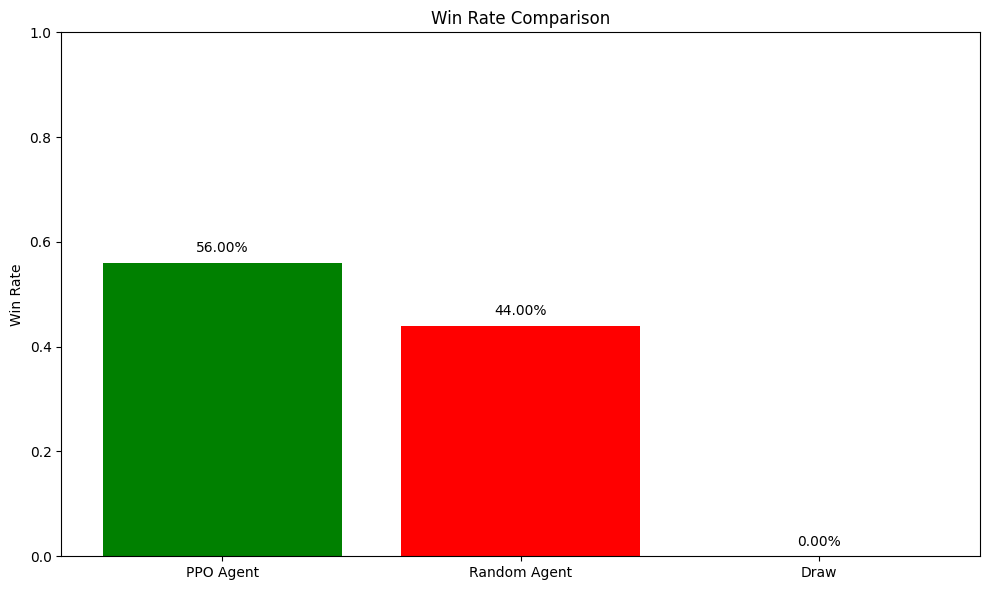

In [ ]:
model_path = "model_weights_PPO/cathedral_ppo_self_play_adversarial_final.pth"

eval_stats = evaluate_ppo_against_random(
    model_path=model_path,
    num_episodes=300,
    board_size=8,
    render=False
)

# Create a bar chart of win rates
labels = ['PPO Agent', 'Random Agent', 'Draw']
values = [eval_stats['ppo_win_rate'], eval_stats['random_win_rate'], eval_stats['draw_rate']]
colors = ['green', 'red', 'gray']

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)
plt.title('Win Rate Comparison')
plt.ylabel('Win Rate')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2%}', ha='center')

plt.tight_layout()
plt.savefig('ppo_vs_random_evaluation.png')
plt.show()

### Train against a random agent

In [ ]:
def train_ppo_random(name):
    env = cathedral_v0.env(board_size=board_size, render_mode="text", per_move_rewards=True, final_reward_score_difference=False)
    env.reset()
    
    # Get action space and observation shape (should be the same for both players)
    player_0 = "player_0"
    
    n_actions = env.action_space(player_0).n
    obs_shape = env.observe(player_0)["observation"].shape  # (10, 10, 5)
    
    print(f'n_actions: {n_actions}')
    print(f'observation shape: {obs_shape}')
    
    # Initialize PPO agent (will be used for both players)
    ppo_agent = PPOCNN(
        obs_shape=obs_shape,
        action_dim=n_actions,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip
    )
    
    # Training statistics
    list_reward_p0 = []
    list_reward_p1 = []
    policy_checkpoints = []
    list_win_count_p0 = [0]  # Initialize with 0
    list_win_count_p1 = [0]  # Initialize with 0
    list_draw_count = [0]    # Initialize with 0
    
    # Training loop
    for episode in range(num_episodes):
        print(f'Episode {episode}')
        env.reset()
        print(f"Starting player: {env.agent_selection}")
        total_reward_p0 = 0
        total_reward_p1 = 0
        episode_timesteps = 0
        
        # Clear player buffer
        ppo_agent.buffer.clear()
        
        # Run the game until completion
        while env.agents:  # Continue while there are still active agents
            current_agent = env.agent_selection
            episode_timesteps += 1
            observation = env.observe(current_agent)
            legal_moves = [i for i, valid in enumerate(observation["action_mask"]) if valid]
            
            if current_agent == player_0:  # PPO agent's turn
                
                state = observation["observation"]
                action_mask = observation["action_mask"]
                
                # Use PPO to select action
                action = ppo_agent.select_action(state, action_mask)
                
                # Take action in environment
                env.step(action)
                
                # Get reward and add to buffer
                reward = env.rewards[current_agent]
                print(f'reward {reward}')
                ppo_agent.buffer.rewards.append(reward)
                
                # Track total rewards
                total_reward_p0 += reward
                
                # Check if episode is done for this agent
                if current_agent not in env.agents:
                    ppo_agent.buffer.is_terminals.append(1)
                    print(f'Appended 1 to terminal')
                else:
                    ppo_agent.buffer.is_terminals.append(0)
                    #print(f'Appended 0 to terminal')
                
            else:  # Random agent's turn
                observation = env.observe(current_agent)
                action_mask = observation["action_mask"]
                
                # Random valid action
        
                action = np.random.choice(legal_moves)
                
                # Take action in environment
                env.step(action)
                
                # Track total rewards (don't add to PPO buffer)
                reward = env.rewards[current_agent]
                #print(f'reward {reward}')
                
                total_reward_p1 += reward
        
        # At this point, the game has ended
        print(f'Timesteps of the episode: {episode_timesteps}')
        
        if current_agent == player_0:
            # We've already counted player_0's reward, but we need to account for player_1's final reward
            total_reward_p1 += env.rewards["player_1"]
        else:
            # We've already counted player_1's reward, but we need to account for player_0's final reward
            total_reward_p0 += env.rewards["player_0"]
            # Also update the PPO buffer with the correct final reward
            if ppo_agent.buffer.rewards and len(ppo_agent.buffer.rewards) > 0:
                # Replace the last "0" reward with the actual final reward
                ppo_agent.buffer.rewards[-1] = env.rewards["player_0"]
                ppo_agent.buffer.is_terminals[-1] = 1
            
        ppo_agent.update()
        
        # Collect statistics
        print(f'Total rewards p0 {total_reward_p0} and p1 {total_reward_p1}')
        list_reward_p0.append(total_reward_p0)
        list_reward_p1.append(total_reward_p1)
        
        # Update the appropriate counter based on the game outcome
        if env.winner == 0:  # player_0 wins
            list_win_count_p0.append(list_win_count_p0[-1] + 1)
            list_win_count_p1.append(list_win_count_p1[-1])  # Carry forward p1 count unchanged
            list_draw_count.append(list_draw_count[-1])  # Carry forward draw count unchanged
            
        elif env.winner == 1:  # player_1 wins
            list_win_count_p0.append(list_win_count_p0[-1])  # Carry forward p0 count unchanged
            list_win_count_p1.append(list_win_count_p1[-1] + 1)
            list_draw_count.append(list_draw_count[-1])  # Carry forward draw count unchanged
            
        elif env.winner == -1:  # draw
            list_win_count_p0.append(list_win_count_p0[-1])  # Carry forward p0 count unchanged
            list_win_count_p1.append(list_win_count_p1[-1])  # Carry forward p1 count unchanged
            list_draw_count.append(list_draw_count[-1] + 1)
        
        if (episode + 1) % 100 == 0:
            win_rate_p0 = list_win_count_p0[-1] / (episode + 1)
            win_rate_p1 = list_win_count_p1[-1] / (episode + 1)
            draw_rate = list_draw_count[-1] / (episode + 1)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Player 0 - Avg Reward: {sum(list_reward_p0[-100:]) / 100:.2f} - Win Rate: {win_rate_p0}")
            print(f"  Player 1 - Avg Reward: {sum(list_reward_p1[-100:]) / 100:.2f} - Win Rate: {win_rate_p1}")
            print(f"  Draw Rate: {draw_rate:.2f}")
            
        # Save checkpoint
        if (episode+1) % 500 == 0:
            policy_checkpoints.append(ppo_agent.policy.state_dict())
            print("Checkpoint saved")
            
            # Save model
            os.makedirs("model_weights_PPO", exist_ok=True)
            ppo_agent.save(f"model_weights_PPO/{name}_{episode+1}.pth")
    
    # Save final model and training statistics
    os.makedirs("model_weights_random_PPO", exist_ok=True)
    print(f'Saving final model')
    torch.save({
        'model_state_dict': ppo_agent.policy.state_dict(),
        'list_reward_p0': list_reward_p0,
        'list_reward_p1': list_reward_p1,
        'list_win_count_p0':list_win_count_p0,
        'list_win_count_p1':list_win_count_p1, 
        'list_draw_count': list_draw_count,
        'policy_checkpoints': policy_checkpoints,
        'num_checkpoints': len(policy_checkpoints)
    }, f"model_weights_random_PPO/{name}_final.pth")
    
    env.close()
    
    return list_reward_p0, list_reward_p1, list_win_count_p0, list_win_count_p1, list_draw_count

In [ ]:
rewards_p0, rewards_p1, win_counts_p0, win_counts_p1, draw_counts = train_ppo_random("cathedral_ppo_vs_random")

n_actions: 1753
observation shape: (8, 8, 5)
Loading PPO CNN with 5, height 8, width 8
Loading PPO CNN with 5, height 8, width 8
Episode 0
Starting player: player_0
reward 0
reward 0
reward -1
reward 0
reward -2
reward -3
reward -1
reward -4
reward -2
reward 6
reward 0
Timesteps of the episode: 20
Total rewards p0 3 and p1 -28
Episode 1
Starting player: player_0
reward 0
reward 0
reward -4
reward -3
reward -2
reward 1
reward -4
reward -2
reward -2
reward 0
reward 10
Appended 1 to terminal
Timesteps of the episode: 21
Total rewards p0 -6 and p1 -27
Episode 2
Starting player: player_0
reward 0
reward -3
reward -2
reward -3
reward 3
reward -1
reward -4
reward -4
reward -1
Timesteps of the episode: 18
Total rewards p0 -25 and p1 -8
Episode 3
Starting player: player_0
reward 0
reward -3
reward -2
reward 0
reward 0
reward -4
reward 6
reward -2
reward -1
reward 0
reward 10
Appended 1 to terminal
Timesteps of the episode: 20
Total rewards p0 4 and p1 -22
Episode 4
Starting player: player_1
rew